In [2]:
import numpy as np
import cv2 as cv
import math
import random
from collections import Counter
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [1]:
class Forest:
    def __init__(self,size,indiviual_reward_importance,social_reward_importance, p_change_wind, type_plane, P_burn, P_set_fire, P_fire_depend_on_wind):
        self.indiviual_reward_importance = indiviual_reward_importance
        self.social_reward_importance = social_reward_importance
        self.grid_env = np.zeros((size,size))  #0: safe, 1: on fire, 2:burnt
        self.grid_type = np.zeros((size,size))  # -1: station, 0: non_tree, 1: tree, 2: home
        self.init_grid(type_plane)
        self.wind_strength = 1
        self.wind_direction = 0  # four direction
        self.p_change_wind = p_change_wind # 0 or 0.0001
        self.change_wind()
        self.P_burn = P_burn# on fire=>burnt
        self.P_set_fire = P_set_fire# neighbourhood on fire
        self.P_fire_depend_on_wind = P_fire_depend_on_wind# neighbour on fire != direction wind => +, else =>-
        self.episode = []
        self.burnt_trees = 0
        self.fired_trees = 0
        self.init_fire(1)

    def neighbours(self,i,j):
        neighbours = {'0':(i, j+1),'1':(i- 1, j),'2':(i, j- 1),'3':(i+1, j)}
        if i == 0 and j == 0 :
          neighbours = {'0':(i, j+1),'3':(i+1, j)}
        elif i == 0 and j == self.grid_env.shape[0] - 1:
          neighbours = {'2':(i, j- 1),'3':(i+1, j)}
        elif i == self.grid_env.shape[0] - 1 and j == 0:
          neighbours = {'0':(i, j+1),'1':(i- 1, j)}
        elif i == self.grid_env.shape[0] - 1 and j == self.grid_env.shape[0] - 1:
          neighbours = {'1':(i- 1, j),'2':(i, j- 1)}
        elif i == 0 : 
          neighbours = {'0':(i, j+1),'2':(i, j- 1),'3':(i+1, j)}
        elif i == self.grid_env.shape[0] - 1:
          neighbours = {'0':(i, j+1),'1':(i- 1, j),'2':(i, j- 1)}
        elif j == 0 : 
          neighbours = {'0':(i, j+ 1),'1':(i- 1, j),'3':(i+1, j)}
        elif j == self.grid_env.shape[0] - 1 : 
          neighbours = {'1':(i- 1, j),'2':(i, j- 1),'3':(i+1, j)}
        return neighbours

    def init_fire(self, init_point_number):# return mean position
        #random between 1 to 4
        #check not station and none_tree

        points = []
        size = self.grid_env.shape[0]
        for i in range(init_point_number):
            flag = True
            while flag: # check if not station  and none tree
                X1 = np.random.choice(range(size))
                X2 = np.random.choice(range(size))
                #print(X1,X2)
                if self.grid_type[X1][X2] == -1 or self.grid_type[X1][X2] == 0 :
                    flag = True
                else:
                    points.append((X1,X2))
                    flag = False
                    break
            self.grid_env[X1][X2] = 1
            neighbours = list(self.neighbours(X1,X2).values())
            for i in neighbours:
                self.grid_env[i[0]][i[1]] = 1
        return points
    # erfan : Range wind ?? 
    def change_wind(self):
        """
        Input : -- 
        Output : self.wind_strength, self.wind_direction
        Choose the wind direction and its strenghth randomly.  
        0 : Right , 1 : Up , 2 : left , 3 : Down 
        """
        self.wind_direction = random.choice([0,1,2,3])
        self.wind_strength += random.uniform(-0.2,0.2)* self.wind_strength
        self.wind_strength = float("{:.3f}".format(self.wind_strength))
        return self.wind_strength,self.wind_direction 
    # man
    def init_grid(self, type_plane):
        # -1: station, 0: non_tree, 1: tree, 2: home
        m = len(self.grid_type)
        station_position = [np.random.choice([i for i in range(m)]),np.random.choice([i for i in range(m)])]
        #print(station_position)
        for i in range(m):
            for j in range(m):
                self.grid_type[i][j] = np.random.choice(type_plane[0], p= type_plane[1])
        winSize = 1
        for i in range(m- 2* winSize):
            for j in range(m- 2* winSize):
                self.grid_type[i+winSize][j+winSize] = int(np.mean(self.grid_type[i:i+2*winSize,j:j+2*winSize]))
        self.grid_type[station_position[0]][station_position[1]] = -1
        #print(self.grid_type)
        return self.grid_type
    # man
    def render(self,agents_position):#opencv, show state, show info
        m = len(self.grid_type)
        pad = 10
        img = np.zeros((m*pad+pad,m*pad,3), np.uint8)
        for i in range(m):
            for j in range(m):
                if self.grid_env[i][j] == 0:
                    if self.grid_type[i][j] == 2:
                        c = (190,0,0)
                    elif self.grid_type[i][j] == -1:
                        c = (0,240,240)
                    elif self.grid_type[i][j] == 1:
                        c = (0,190,0)
                    else:
                        c = (30,105,210)
                elif self.grid_env[i][j] == 1:
                    c = (0,0,247)
                else:
                    c = (0,0,0)
                img[i*pad:(i+1)*pad,j*pad:(j+1)*pad] = c
        font                   = cv.FONT_HERSHEY_SIMPLEX
        bottomLeftCornerOfText = (0,m*pad+pad)
        fontScale              = 1
        fontColor              = (255,255,255)
        lineType               = 2
        txt = "Wind Direction:" + str(self.wind_direction) +" strength:" + str(self.wind_strength)
        cv.putText(img,txt, bottomLeftCornerOfText, font, fontScale,fontColor, lineType)
        for a in agents_position:
            cv.circle(img,(a[0]*pad+int(pad/2),a[1]*pad+int(pad/2)),int(pad/2), (255,0,255), -1)
        cv.imwrite("T.jpg", img)
        self.episode.append(img)
        self.episode.append(img)
        self.episode.append(img)
        return
    def save_episode(self):#save episode to video
        m = len(self.grid_type)
        pad = 10
        frameSize = (m*pad+pad,m*pad)
        video_path = 'out.avi'
        height, width, channels = self.episode[0].shape
        video = cv.VideoWriter(video_path,cv.VideoWriter_fourcc(*'DIVX'), 10,(width, height))  
        for img in self.episode:
            video.write(img)

        cv.destroyAllWindows()
        video.release()
        print("video saved")
        return

    # amir
    def reset(self):#init
        size = self.grid_env.shape[0]
        self.wind_strength = 0
        self.wind_direction = 0
        self.episode = []
        self.grid_env = np.zeros((size,size))
        self.grid_type = np.zeros((size,size))
        self.init_grid(type_plane)
        self.change_wind()
        self.init_fire(1)
        return


    def get_neighbours_on_fire (self,grid_env, point): # return neighbours in fire and their direction
        on_fires_direction = []
        # 0 : Right || 1 :Up || 2 : Left || 3 : Down
        i = point[0]
        j = point[1]
        neighbours = self.neighbours(i,j)
        for n in range(len(neighbours)):
            neighbour = list(neighbours.values())[n]
            direction = list(neighbours.keys())[n]
            if grid_env[neighbour[0]][neighbour[1]]:
                on_fires_direction.append(int(direction))
        return on_fires_direction
    def get_p_fire (self, alpha, neighbours_on_fire):
        """
        input : gets neighbours on fire and their direction
        output: calculate p_fire base on wind direction 
        """
        p_fire = 1
        higher_alpha = 0.9
        for i in neighbours_on_fire:
            if i == self.wind_direction:
                p_fire = p_fire * higher_alpha
            else :
                p_fire = p_fire * alpha
        return p_fire


    def P_transitions(self):#burnt => burnt, on fire => P_1(init,wind) => burnt, neighbour on fire => set on fire with p and wind
        alpha = 0.7
        copy_env = np.zeros((self.grid_env.shape[0],self.grid_env.shape[0])) +self.grid_env
        for i in range(self.grid_env.shape[0]):
            for j in range(self.grid_env.shape[0]):
                on_fire_neighbours = self.get_neighbours_on_fire(copy_env,(i,j))
                if copy_env[i][j] == 0:
                    if self.grid_type[i][j] !=-1 and self.grid_type[i][j] != 0:
                        p_fire = self.get_p_fire(alpha,on_fire_neighbours)
                        # alpha based on wind direction
                        # 0 : Right , 1 : Up , 2 : left , 3 : Down
                        new_state = np.random.choice([0,1], p=[p_fire,1 - p_fire])
                        self.grid_env[i][j] = new_state
                elif copy_env[i][j] == 1:
                    newstate = np.random.choice([1,2], p=[1- self.P_burn,self.P_burn])
                    self.grid_env[i][j] = newstate       


                    # if newstate == 2 :
                    #   neighbours = list(self.neighbours(i,j).values())
                    #   for n in neighbours:
                    #     if copy_env[n] == 0 and self.grid_type[i][j] > 0:
                    #        self.grid_env[n] = 1
                    #        break

        # with a p call chenge_wind
        #print(copy_env)
        return
    def get_env_give_tree(self, first_env, second_env):
        safe_counter, new_safe_counter = 0,0
        burnt_counter, new_burnt_counter = 0,0
        for i in range(first_env.shape[0]):
            for j in range(first_env.shape[1]):
                if first_env[i][j] ==0:
                    safe_counter +=1
                elif first_env[i][j] ==2:
                    burnt_counter +=1
        for i in range(first_env.shape[0]):
            for j in range(first_env.shape[1]):
                if second_env[i][j] ==0:
                    new_safe_counter +=1
                elif second_env[i][j] ==2:
                    new_burnt_counter +=1
        burnt_trees = new_burnt_counter - burnt_counter
        fired_trees = safe_counter - new_safe_counter
        return burnt_trees, fired_trees                                                                  
    # erfan : 1.action ? 2. Ba 1 bar made pashidan khamoosh beshe ? 3. different Time step for Env Transition and agent ?
    # 4.position ?  5.self.p_transition ??
    def is_border(self,x,y):
        """
        This function get the position of the agent and return True if there is one safe tree or home grid with manhatan distance = 1
        """
        is_border = False
        neighbors  = list(self.neighbours(x,y).values())
        if self.grid_env[x,y] != 1 : 
            return is_border
        for neigh in neighbors: 
            if self.grid_env[neigh] == 0 and self.grid_type[neigh] > 0 :
                is_border = True
                break 
        return is_border
    
    
    def next_state(self,action, position, env_transition = True):#action=fire_retardent on fire => tree , call P_transition, with a p change_wind
        """
        Input : action : include control actions of all agents || env_transition = determine whether to change environment based on                   passing time
        Output: Updated self.grid_env
        Change the dynamic of environment based on agents' actions or passing time. 
        """
        grid_env_p = np.copy(self.grid_env)
        if action is not None :
            for i in range(len(action)):
                x, y = position[i]
                if action[i][0] == 1 and self.grid_env[x,y] == 1 :
                    self.grid_env[x,y] = 0
                     
        if env_transition : 
            # call P_transition method

            self.P_transitions()
            # for idx, x in np.ndenumerate(self.grid_env): 
            #     if x ==  0:   
            #         self.grid_env[idx] = random.choices([0,1,2],weights = self.P_transition[0,:])[0]
            #     elif x == 1:
            #         self.grid_env[idx] = random.choices([0,1,2],weights = self.P_transition[1,:])[0]
        self.burnt_trees, self.fired_trees = self.get_env_give_tree(grid_env_p,self.grid_env)
        return self.grid_env
    # erfan : 1.Unit test ?
    def calculate_reward(self, action, position):
        # state=[3X3],[3X3],x,y,mean_x_fire,mean_y_fire
        # Action: fire_r => 0,1 , move => 0,...,8, help => 0,1, =>[[0,1],[0,...,8],[0,1]]
        # individual: collision => -- , healthy retardant => -, on_fire on border=> ++, on_fire=>+,
        #social: for each new burnt tree=>-, for each new burnt home=>--,
        # action = fire_retardant:
        # ind_r = if home: on_fire => safe => 3*r1
        #         elif tree: on_fire => safe => 2*r1
        #         elif   station or non_tree => -2*r1
        #         border(at least one neigh safe and not non_tree): on_fire => safe => r1
        # move => if collision: -10*r1
        # help => -10*r1
        
        r1 = 5
        new_position = position
        ind_r = np.zeros((len(action),1))
        social_r = np.zeros((len(action),1))
        num_rep_pos = dict(Counter(new_position))
        for i in range(len(action)):
            x, y = position[i]
            if action[i][0] == 1 : 
                if self.grid_env[x,y] == 0 or self.grid_env[x,y] == 2:
                    ind_r[i,:] -= r1
                    if self.grid_type[x,y] == -1 or self.grid_type[x,y] == 0:
                        ind_r[i,:] -= r1

                else : 
                    if self.grid_type[x,y] == 1:
                        ind_r[i,:] += 2*r1
                    elif self.grid_type[x,y] == 2:
                        ind_r[i,:] += 3*r1
                    if self.is_border(x,y) == True:
                        ind_r[i,:] += r1
                ind_r[i,:] += 10* r1
            if num_rep_pos[new_position[i]] > 1 : 
                ind_r[i,:] -= 10*r1
            if action[i][2] == 1 :
                ind_r[i,:] -= 10*r1 
            social_r[i,:] = -1* r1 *self.burnt_trees -1 * r1* self.fired_trees

        # social_r:
        # -1*#new_burnt -1*#new_home_burnt -1*#new_on_fire -1*#new_home_on_fire 
        # returns self.indiviual_reward_importance* ind_r + self.social_reward_importance * social_r for each agent
        total_r = self.indiviual_reward_importance* ind_r + self.social_reward_importance * social_r

        #print("ind reward : ", ind_r)
        #print("social reward : ", social_r)
        return total_r
    # amir
    def terminated(self):#no on fire
        terminated = True
        for i in range(self.grid_env.shape[0]):
            for j in range(self.grid_env.shape[0]):
                if self.grid_env[i][j] == 1:
                    terminated = False
                    break
        return terminated
    # erfan : 1.Add tree as padding or what ?? 2. position of single agent or all ?? 
    # test video
  
    def observe(self, l, w, position):
        """
        Input : l: length of scope of IR Camera || w : length of scope of IR Camera || postion : one Agent position 
        Output : Situatuion of l*w grids in the agent scope
        A downward facing Infrared (IR) camera captures the states of an l * w sized grid of trees.The agent is located at the center         of the image and if images are taken at an edge of the forest, the image is padded with non-trees.
        """
        assert l % 2 == 0 and w % 2 == 0 , "l and w should be an even integer"
        x,y = position 
        X,Y = self.grid_env.shape
        X = X - 1 
        Y = Y - 1 
        dpad_x = max(int(x + l/2) - X, 0)
        upad_x = max(0 - int(x - l/2),0)
        rpad_y = max(int(y + w/2) - Y,0)
        lpad_y = max(0 - int(y - w/2),0)
        #print(lpad_y,rpad_y,upad_x,dpad_x)
        grid1 = np.pad(self.grid_env, ((upad_x,dpad_x),(lpad_y,rpad_y)), 'constant', constant_values = 0)
        grid2 = np.pad(self.grid_type, ((upad_x,dpad_x),(lpad_y,rpad_y)), 'constant', constant_values = 0)
        #print(int(x- l/2)+upad_x,int(x + l/2)+upad_x+1,int(y-w/2)+lpad_y, int(y+w/2)+lpad_y+1)
        #print(grid1.shape)
        return grid1[int(x- l/2)+upad_x:int(x + l/2)+upad_x+1,int(y-w/2)+lpad_y: int(y+w/2)+lpad_y+1],grid2[int(x- l/2)+upad_x:int(x + l/2)+upad_x+1,int(y-w/2)+lpad_y: int(y+w/2)+lpad_y+1]
    # man
    def step(self, action, position):#,env_transition): #next_state, calculate_reward, check terminate
        self.next_state(action, position)
        r = self.calculate_reward(action, position)
        obsv = []
        for p in position:
            obsv.append(self.observe(2,2,p))
        #self.last_position = positions
        return r, self.terminated(), obsv 
    def mean_fire_pos(self):
        fire_pos = []
        for idx in range(len(self.grid_env)):
          for idx2 in range(len(self.grid_env)):
            if self.grid_env[idx][idx2] == 1 : 
                fire_pos.append(np.array([idx,idx2]))
        if len(np.array(fire_pos)) == 0:
          return 0,0
        a = np.average(np.array(fire_pos),axis = 0)
        return int(a[0]), int(a[1])

In [ ]:
f = Forest(size,indiviual_reward_importance,social_reward_importance, p_change_wind, type_plane, P_burn, P_set_fire, P_fire_depend_on_wind)
print(f.grid_env)
f.P_transitions()
print(f.grid_env)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 2. 2. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [3]:
'''class DeepQNetwork(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims, 
            n_actions):
        super(DeepQNetwork, self).__init__()
        #print(input_dims, fc1_dims, fc2_dims, 
        #    n_actions)
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.fc1 = nn.Linear(self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        #add layer
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        out = []
        output = []
        if np.array(state).ndim == 1:
          state = [state]
        for st in state:
          st = T.tensor(st, dtype = T.float32)
          x = F.relu(self.fc1(st))
          x = F.relu(self.fc2(x))
          actions = F.softmax(self.fc3(x))
          action_p = np.zeros(actions.size()[0])
          index = T.argmax(actions)
          action_p[index] = 1
          out.append(action_p)
        if len(out) == 1:
          output = T.tensor(out[0], dtype = T.int32)
        else:
          output = T.reshape(T.from_numpy(np.array(out).ravel()),(16,36))
          print(output.size())
        #print("output:")
        #print(output)
        return output'''
class DeepQNetwork(nn.Module): 
   def __init__(self, lr, input_dims, fc1_dims, fc2_dims,  n_actions):
        super(DeepQNetwork, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(input_dims, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, n_actions)
        )

   def forward(self, features):
     return self.network(features.float())

In [4]:



import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from collections import defaultdict
import copy
import numpy as np
import os
import sys
import time


In [5]:

class mini_Agent:
    def __init__(self,id, level, parent,env, read = None, input_dims = 22,  n_actions = 36 ,batch_size = 16,gamma = 0.9, epsilon=0.9, lr=0.1,
            max_mem_size=10000, eps_end=0.05, eps_dec=5e-4): 
        self.model = DeepQNetwork(lr, n_actions=n_actions, input_dims=input_dims,fc1_dims=128, fc2_dims=128)
        self.target = DeepQNetwork(lr, n_actions=n_actions, input_dims=input_dims,fc1_dims=128, fc2_dims=128)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

        self.sars = None
        self.eps = 1
        self.reward_history = []
        self.loss_history = []
        self.num_train_episodes = 0
        self.print_enough_experiences = False
        

        
        self.id = id 
        self.level = level
        self.n_actions = n_actions
        self.parent = parent 
        # random ?? np.array or tuple ?? 
        size = env.grid_env.shape[0]
        x = random.randint(0, size-1)
        y = random.randint(0, size-1)
        self.position = (x,y)
        # Broadcast ??
        mean_x_fire, mean_y_fire = env.mean_fire_pos()
        self.mean_pos_fire = (mean_x_fire, mean_y_fire)

        self.observ1, self.observ2 = env.observe(2,2,self.position)
        self.observ = [self.observ1,self.observ2,self.position,self.mean_pos_fire]
        self.best_SARS = [self.observ,[0,0,0],0,self.observ,0]
        self.action_list = []
        for i in range(2):
            for j in range(9):
                for k in range(2):
                    self.action_list.append([i,j,k])
        #id,memory,...
        # position
        # meanx, meany
        # best_state_action_R
        self.action_space = [i for i in range(n_actions)]
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.lr = lr
        self.past_position = (0,0)
        self.action_space = [i for i in range(n_actions)]
        self.configdtype = torch.tensor
        self.mem_size = max_mem_size
        self.batch_size = batch_size
        self.replace_target = 4
        self.min_exp = 10
        self.loss_fn = nn.MSELoss(reduction='mean')
        self.input_dims = input_dims
        self.model_updates = 0
        if read is not None:
            self.load_checkpoint(read)
        '''
        self.mem_cntr = 0
        self.iter_cntr = 0
        # n_actions,input_dims in the input ??
        self.Q_eval = DeepQNetwork(lr, n_actions=n_actions, input_dims=input_dims,
                                    fc1_dims=128, fc2_dims=128)
        self.Q_next = DeepQNetwork(lr, n_actions=n_actions, input_dims=input_dims,
                                    fc1_dims=64, fc2_dims=64)
                            
        self.state_memory = np.zeros((self.mem_size, input_dims), dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, input_dims), dtype=np.float32)
        self.action_memory = np.zeros((self.mem_size,n_actions), dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)'''

    def save_checkpoint(self):
        checkpoint = {
            'state_dict': self.model.state_dict(),
            'target_dict': self.target.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'replay': self.sars,
            'epsilon': self.eps,
            'reward_history': self.reward_history,
            'loss_history': self.loss_history,
            'num_train_episodes': self.num_train_episodes
        }
        filename =  'madqn-' +str(self.id)+ '.pth.tar'
        torch.save(checkpoint, filename)
        
    def load_checkpoint(self,id):
        filename =  'madqn-' +str(id)+ '.pth.tar'
        checkpoint = torch.load(filename)
        self.model.load_state_dict(checkpoint['state_dict'])

        self.target.load_state_dict(checkpoint['target_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.sars = checkpoint['replay']
        self.eps = checkpoint['epsilon']
        self.reward_history = checkpoint['reward_history']
        self.loss_history = checkpoint['loss_history']
        self.num_train_episodes = checkpoint['num_train_episodes']

    def store_transition(self, state, action, reward, state_, terminal):
        #print("store_transition")
        l = list(np.array(state[0]).flatten().astype(int)) + list(np.array(state[1]).flatten().astype(int))
        #print("store", state)
        l.append(int(state[2][0]))
        l.append(int(state[2][1]))
        l.append(int(state[3][0]))
        l.append(int(state[3][1]))
        new_state = np.array(l)
        l = list(np.array(state_[0]).flatten().astype(int)) + list(np.array(state_[1]).flatten().astype(int))
        l.append(int(state_[2][0]))
        l.append(int(state_[2][1]))
        l.append(int(state_[3][0]))
        l.append(int(state_[3][1]))
        new_state_ = np.array(l)
        #print("store", action)
        if len(action) > 1:
          new_action = self.action_list.index(action)
        data = np.zeros((1, 2*len(new_state) + 1 + 1))
        data[0, 0:len(new_state)] = new_state
        
        data[0, len(new_state)] = new_action
        reward_idx = len(new_state) + 1
        data[0, reward_idx] = reward
        next_features_idx = len(new_state)+1+1
        data[0, next_features_idx:] = new_state_
        
        if self.sars is None:
          self.sars = data
        else:
          self.sars = np.vstack((self.sars, data))
        # drop from memory if too many elements
        if self.sars.shape[0] > self.mem_size:
          if self.sars.shape[0]-self.mem_size > self.batch_size:
            sars = []
            for i in range(int((self.sars.shape[0]-self.mem_size)/2)):
              sars.append(self.sars[int((self.sars.shape[0]-self.mem_size)/2) + i -1])
        '''
        index = self.mem_cntr % self.mem_size
        l = list(np.array(state[0]).flatten().astype(int)) + list(np.array(state[1]).flatten().astype(int))
        l.append(int(state[2][0]))
        l.append(int(state[2][1]))
        l.append(int(state[3][0]))
        l.append(int(state[3][1]))
        self.state_memory[index] = T.tensor(l).type(T.LongTensor)
        l = list(np.array(state_[0]).flatten().astype(int)) + list(np.array(state_[1]).flatten().astype(int))
        l.append(int(state_[2][0]))
        l.append(int(state_[2][1]))
        l.append(int(state_[3][0]))
        l.append(int(state_[3][1]))
        self.new_state_memory[index] = T.tensor(l).type(T.LongTensor)
        self.reward_memory[index] = reward
        #print(self.action_memory.shape)
        #print(action)
        indx = self.action_list.index(action)
        array = np.zeros(self.n_actions)
        array[indx] = 1
        self.action_memory[index] =  T.tensor(array).type(T.LongTensor)
        self.terminal_memory[index] = terminal
        self.mem_cntr += 1'''
        if self.best_SARS[2] < reward:
            self.best_SARS = [state, action, reward, state_, terminal]
        
    def update_Q_network(self):
        #print("updating Q net for agent"+str(self.id))
        if self.sars is None or self.sars.shape[0] < self.min_exp or self.sars.shape[0] < self.batch_size:
          return
        #print("in update")
        # create mini-batch
        #print("sars: ",self.sars)
        batch = self.sars[np.random.choice(self.sars.shape[0], self.batch_size, replace=False), :]
        batch_features = torch.from_numpy(batch[:, 0:self.input_dims])
        batch_features = Variable(batch_features.int())
        batch_actions = torch.from_numpy(batch[:, self.input_dims]).type(torch.int64)
        batch_actions = Variable(batch_actions)
        x = self.model(batch_features.float()).gather(1, batch_actions.view(-1, 1)).squeeze()

        # calculate loss
        batch_rewards = batch[:, self.input_dims+1]
        next_features_idx = self.input_dims+1+1
        batch_next_features = Variable(torch.from_numpy(batch[:, next_features_idx:]))
        tt = self.target(batch_next_features.float()).data.cpu().numpy()
        tt = batch_rewards + self.gamma*np.amax(tt, axis=1)
        tt = Variable(torch.from_numpy(tt).float(), requires_grad=False)
        loss = self.loss_fn(x, tt)

        self.loss_history.append(loss.item())

        # back propagate
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min
        if self.model_updates % self.replace_target == 0:
          self.target = copy.deepcopy(self.model)
        self.model_updates += 1
        '''
        if self.mem_cntr < self.batch_size:
            return
        #print("after if")

        self.Q_eval.optimizer.zero_grad()
        
        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, self.batch_size, replace=False)
        
        batch_index = np.arange(self.batch_size, dtype=np.int32)

        state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
        action_batch = self.action_memory[batch]
        reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
        terminal_batch = T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)
        #????
        #print(self.Q_eval(state_batch),self.Q_eval(state_batch).shape)
        #l = self.action_list.index(action)
        #print(self.Q_eval(state_batch))
        q_eval = self.Q_eval(state_batch)[batch_index,action_batch]
        q_next = self.Q_eval(new_state_batch)
        q_next[terminal_batch] = 0.0

        q_target = reward_batch + self.gamma*T.max(q_next,dim=1)[0]

        loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
        loss.backward()
        self.Q_eval.optimizer.step()
        #print("out of function")

        self.iter_cntr += 1
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min \
                       else self.eps_min'''

    def heuristic(self):
      action = [0,0,0]
      # if agent reached fire, move on the fire boundary to apply retardant
      if self.observ1[1][1] == 1:
        action[0] = 1
      if True:
        # find the action that is closest to simply rotating clockwise about the fire center
        if self.position[0]<self.mean_pos_fire[0]:
          if self.position[1]<self.mean_pos_fire[1]:
            action[1] = 2
          elif self.position[1] == self.mean_pos_fire[1]:
            action[1] = 1
          else:
            action[1] = 8
        elif self.position[0] == self.mean_pos_fire[0]:
          if self.position[1]<self.mean_pos_fire[1]:
            action[1] = 3
          elif self.position[1] == self.mean_pos_fire[1]:
            action[1] = 0
            action[0] = 1
          else:
            action[1] = 7
        else:
          if self.position[1]<self.mean_pos_fire[1]:
            action[1] = 4
          elif self.position[1] == self.mean_pos_fire[1]:
            action[1] = 5
          else:
            action[1] = 6
        fire_center_vector = [self.position[0] - self.mean_pos_fire[0],self.position[1] - self.mean_pos_fire[1]]
      return action


    def choose_action(self,observation):
        #print("choosing action for agent:"+str(self.id))
        if True:#np.array(observation).ndim != 1:
          l = list(np.array(observation[0]).flatten().astype(int)) + list(np.array(observation[1]).flatten().astype(int))
          l.append(float(observation[2][0]))
          l.append(float(observation[2][1]))
          l.append(float(observation[3][0]))
          l.append(float(observation[3][1]))
          observation = np.array(l)
        if np.random.random() > self.epsilon:
            q_features = Variable(torch.from_numpy(observation)).type(T.long)
            q_values = self.model(torch.from_numpy(observation).float())[0].data.cpu().numpy()
            action = self.action_list[np.argmax(q_values)]
        else:
            if np.random.random() > self.epsilon/3:
              action = self.heuristic()
            else:
              action = self.action_list[np.random.choice(self.action_space)] #self.action_space
        return action
    # amir
    def update_state(self,observ1,observ2):
        self.observ[0] = observ1
        self.observ[1] = observ2


        return
    # man
    def update_position(self,action_array, m):
        m = m - 1 
        self.past_position = (self.position[0],self.position[1]) 
        position = self.position
        move = [0,0]
        action = action_array
        if action == 1:
            move = [1,0]
        elif action == 2:
            move = [1,1]
        elif action == 3:
            move = [0,1]
        elif action == 4:
            move = [-1,1]
        elif action == 5:
            move = [-1,0]
        elif action == 6 :
            move = [-1,-1]
        elif action == 7 :
            move = [0,-1]
        elif action == 8:
            move = [1,-1]
        position_new = np.array(position) + move
        if position_new[0]>m or position_new[0]<0 or position_new[1]>m or position_new[1]<0:
            position = position
        else:
            position = (position_new[0],position_new[1])
        self.position = (position[0],position[1])
        return
    


In [6]:
class Agent:
    #amir
    def __init__(self, env, arch, read = None, record_flag=False):
        # init mini_Agents =>[]
        self.counter = 1 
        self.all_agents =  []
        self.env = env
        self.arch = arch
        self.record_flag = record_flag
        if read is not None:
          if read == 1:
            for a in arch:
              self.all_agents.append(mini_Agent(a[0],a[2],a[1],env, a[0])) #[mini_Agent() for i in range(agent_number)]
          else:
            for a in arch:
              self.all_agents.append(mini_Agent(a[0],a[2],a[1],env, 0))
        else:
          for a in arch:
            self.all_agents.append(mini_Agent(a[0],a[2],a[1],env)) #[mini_Agent() for i in range(agent_number)]
        #self.agents_info = 
        # for mini_Agent id,level,parent [id,parent_id,level]
        #
        
        return


    
    def take_action(self, actions, positions):
        #print("taking action")
        #print(actions)
        j = 0
        for i in self.all_agents:
            if actions[j][1]!=0:
              #print("pos changed")
              #print("pos before update pos: ", i.position)
              i.update_position(actions[j][1], len(self.env.grid_env))
              #print("pos after update pos: ", i.position)
            j = j + 1
        #print(positions)
        r,terminated,observations = self.env.step(actions, positions)#,env_transition = self.counter % 4)
        #print("step done with reward of "+str(np.sum(r)))
        for j in range(len(self.all_agents)):
            #i.update_state(observations[j][0],observations[j][1])
            i = self.all_agents[j]
            #if actions[j][2] == 1:
                #self.all_agents.append(mini_Agent(len(self.all_agents), 0,-1,self.env))

        # for each agent state agent update
        # for each agent if action = move => update position
        # for each agent if action == help => init new mini_Agent with Net Queen
        # returns reward, terminated
        self.counter += 1
        return r , terminated,observations
    
    def communicate(self,level):#comunication: level down to up
        # define agents with level 
        lev_1 = [x for x in level if x[2]==0 ]
        lev_2 = [x for x in level if x[2]==1 ]
        lev_3 = [x for x in level if x[2]==2 ]
        all_gents_level = [lev_1, lev_2, lev_3]
        for same_level in all_gents_level:
            for i in same_level:
                parent_i = i[1]
                id_i = i[0]
                agent = self.all_agents[id_i]
                mean_x_fire = self.all_agents[id_i].mean_pos_fire[0] 
                mean_y_fire = self.all_agents[id_i].mean_pos_fire[1]
                counter=0
                same_levels_for_comparison = [] + same_level
                same_levels_for_comparison.remove(i)
                while counter < len(same_levels_for_comparison):
                    new_parent = same_levels_for_comparison[counter][1]
                    new_id = same_levels_for_comparison[counter][0]
                    new_agent = self.all_agents[new_id]
                    if parent_i == new_parent:
                        agent.mean_pos_fire = (int(np.mean([mean_x_fire, new_agent.mean_pos_fire[0]])),int(np.mean([mean_y_fire, new_agent.mean_pos_fire[1]])))
                        #print(new_agent.best_SARS)
                        if (np.sum(new_agent.best_SARS[0][0])+np.sum(new_agent.best_SARS[0][1]) + np.sum(new_agent.best_SARS[1]) + np.sum(new_agent.best_SARS[2]) + np.sum(new_agent.best_SARS[3][0]) + np.sum(new_agent.best_SARS[3][1]) + np.sum(new_agent.best_SARS[4]))   != 0:
                            agent.store_transition(new_agent.best_SARS[0],new_agent.best_SARS[1],new_agent.best_SARS[2],new_agent.best_SARS[3],new_agent.best_SARS[4])
                    counter = counter + 1
        return

    

    def live_one_episode(self):
        # while not terminated:
        #       for each agent:
        #           choose action ( action = mini_agent.choose_action(observation) )
        #           take_action  (reward, done, obsv = env.step(action))
        #           mini_agent.store_transition(observation, action, reward, obsv, done)
        #           communication
        #           mini_agent.store_transition(based on communication)
        #           mini_agent.learn()
        #           observation = obsv
        #           save(score,....?)
        total_R = []
        terminated = False
        while not terminated:
            actions = []
            positions = []
            for j in range(len(self.all_agents)):
                i = self.all_agents[j]
                actions.append(i.choose_action(i.observ))
                positions.append(i.position)
            len_before = len(self.all_agents)
            #print("len before:"+str(len(self.all_agents)))
            reward , terminated, obsv = self.take_action(actions,positions)
            for j in range(len_before):
                i = self.all_agents[j]
                obsp = np.copy(i.observ)
                obsp[2] = i.past_position
                #print(j,len(obsv),len(self.all_agents), len(positions))
                i.observ[0] = obsv[j][0]
                i.observ[1] = obsv[j][1]
                i.observ[2] = i.position
                if any(np.array(i.observ[0]).flatten())==1:
                    #print(i.mean_pos_fire[0],i.position[0])
                    i.mean_pos_fire = (np.mean((i.position[0],i.mean_pos_fire[0])),np.mean((i.position[1],i.mean_pos_fire[1])))
                    i.observ[3] = i.mean_pos_fire
                i.store_transition(obsp,actions[j],reward[j],np.copy(i.observ),terminated)
            self.communicate(self.arch)
            for i in self.all_agents:
                i.update_Q_network()
            #print("1111")
            if self.record_flag :
              self.env.render(positions)
            total_R.append(reward)
        if self.record_flag:
          self.env.save_episode()
        #print("terminated")
        return total_R

        # while not terminated
        #       for each agent choose action
        #       take_action
        #       communication
        #       for each agent update_Q_network based on reward and communication
        
    #communication :(mean_x_fire,mean_y_fire,best_state_action,R,level) 
    #state=[3X3],[3X3],x,y,mean_x_fire,mean_y_fire
    #Action: fire_r => 0,1 , move => 0,...,8, help => 0,1, =>[[0,1],[0,...,8],[0,1]]

In [7]:
pip install geneticalgorithm2

     |████████████████████████████████| 51kB 4.2MB/s 
  Created wheel for func-timeout: filename=func_timeout-4.3.5-cp37-none-any.whl size=15079 sha256=7695dac701c205c3754363953e5c37e5ae581adeaa9b40bf39aeea44e9c35976
  Stored in directory: /root/.cache/pip/wheels/46/7c/4f/24f1d2d5bbff92219debe7ea19af84f76ddeb90dd4ec544f26
Successfully built func-timeout


In [8]:



import numpy as np

from geneticalgorithm2 import geneticalgorithm2 as ga # for creating and running optimization model

from geneticalgorithm2 import Crossover, Mutations, Selection # classes for specific mutation and crossover behavior

from geneticalgorithm2 import Population_initializer # for creating better start population

from geneticalgorithm2 import np_lru_cache # for cache function (if u want)

from geneticalgorithm2 import plot_pop_scores # for plotting population scores, if u want

from geneticalgorithm2 import Callbacks # simple callbacks

from geneticalgorithm2 import Actions, ActionConditions, MiddleCallbacks # middle callbacks

class Genetic:
    #man
    def __init__(self, env, check_point = None):
        self.env = env
        self.k=0
        self.check_point = check_point
        #[i,j,k,n]=> i+j+k = n i=#queen, j=#level1, k=#level2 
        #population random =>p0 => live in env for one episode => fitness => 100 population => best 
        #=> make hirearchy => train => select_best
        return
    def init_start_generation(self,N,min_agents,max_agents):
        start_generation = np.zeros((N, 3))
        for i in range(N):
            while True:
                agent = np.random.choice([i+min_agents for i in range(max_agents+1-min_agents)])
                if agent!=0:
                    break
            Queen = np.random.choice([i for i in range(agent+1)])
            if Queen!=0 and Queen!=agent:
                while True:
                    lv1 = np.random.choice([i for i in range(agent+1-Queen)])
                    if lv1!=0:
                        break
                start_generation[i] = np.array([Queen,lv1,agent-lv1-Queen])
            elif Queen==0:
                lv1 = np.random.choice([i for i in range(agent+1)])
                start_generation[i] = np.array([Queen,lv1,agent-lv1-Queen])
            else:
                start_generation[i] = np.array([Queen,0,0])
        return start_generation
    def make_arch(self,X):
        level = []
        if X[0] ==0 and X[1] == 0:
            for i in range(int(X[2])):
                level.append([i,-1,2])
            return level
        if X[0] ==0 and X[2] == 0:
            for i in range(int(X[1])):
                level.append([i,-1,1])
            return level
        if X[1] ==0 and X[2] == 0:
            for i in range(int(X[0])):
                level.append([i,-1,0])
            return level
        if X[0]==0:
            for i in range(int(X[1])):
                level.append([i,-1,1])
        i = 0
        queen = []
        for q in range(int(X[0])):
            level.append([i,-1,0])
            queen.append(i)
            i = i + 1
        lv1 = []
        for q in range(int(X[1])):
            lv1.append(i)
            i = i + 1
        lv2 = []
        for q in range(int(X[2])):
            lv2.append(i)
            i = i + 1
        temp = np.copy(lv1)
        if len(queen)!=0:
            while True:
                for q in queen:
                    if    len(lv1) == 0:
                        break
                    c = np.random.choice(lv1)
                    lv1.remove(c)
                    level.append([c,q,1])

                if     len(lv1) == 0:
                    break
        if len(temp)!=0:
            while True:
                for q in temp:
                    if    len(lv2) == 0:
                        break
                    c = np.random.choice(lv2)
                    lv2.remove(c)
                    level.append([c,q,2])

                if     len(lv2) == 0:
                    break 
        return level
    def fitness_function(self,X):
        #print("ep"+str(self.k))
        self.k = self.k + 1
        arch = self.make_arch(X)
        agents = Agent(self.env,arch,self.check_point)
        Total = []
        for i in range(2):
          r = agents.live_one_episode()
          self.env.reset()
          sum = 0
          for x in r:
            sum = sum + np.sum(x)
          Total.append(sum)
        #print("Reward")
        sum = np.sum(Total)
        #print(sum)
        return -1*sum
    def my_mutation(self,current_value, left_border, right_border):
        #print("muting")
        #print(current_value, left_border, right_border)
        return
    def my_crossover(self,parent_a, parent_b):
        child_1 = [int(parent_a[0]),int(parent_a[1]),int(parent_b[2])]
        if child_1[1] == 0:
            if child_1[2] !=0 and child_1[0]!=0:
                child_1[1] = 1
            if child_1[2] ==0 and child_1[0]==0:
                child_1[1] = 1
        child_2 = [int(parent_b[0]),int(parent_b[1]),int(parent_a[2])]
        if child_1[1] == 0:
            if child_1[2] !=0 and child_1[0]!=0:
                child_1[1] = 1
            if child_1[2] ==0 and child_1[0]==0:
                child_1[1] = 1
        return np.array(child_1), np.array(child_2)
    def train(self):
        start_generation = self.init_start_generation(100,0,5)
        varbound=np.array([[0,5]]*3)
        model = ga(function = self.fitness_function, dimension = 3, variable_type='int', variable_boundaries = varbound ,variable_type_mixed = None, function_timeout = 10,
                 algorithm_parameters={'max_num_iteration': None,
                                       'population_size':100,
                                       'mutation_probability':1,
                                       'elit_ratio': 0.01,
                                       'crossover_probability': 0.5,
                                       'parents_portion': 0.3,
                                       'crossover_type':self.my_crossover,
                                       'mutation_type': self.my_mutation,
                                       'selection_type': 'roulette',
                                       'max_iteration_without_improv':None}
            )
        model.run(no_plot = False, start_generation={'variables': start_generation, 'scores': None})
        convergence = model.report
        return convergence


In [16]:
def main_func(arch, env, read = None,record = False ):
    agents = Agent(env,arch, read,record)
    Total_r = []
    for i in range(100):
        print("-------------------------------------------------------")
        print("episode Of : ", i)
        r = agents.live_one_episode()
        #print("reward of "+str(i)+"th iteration is:" + str(r))
        env.reset()
        Total_r.append(r)
    for agent in agents.all_agents:
      agent.save_checkpoint()
    return Total_r, agents

Genetic -> best_architecture -> train
Genetic -> population -> each chromosome one ep live -> mutation, cross_over -> best_architecture
train -> live for many episode


class Genetic:
    arch => live_one_ep => comulative reward of ep 

class Agent:
    arch => init mini_Agent
    episode:
        while not terminated:
            for each agent: 
                choose_action 
            take action
            update_agent and env

In [10]:
size = 10 
indiviual_reward_importance = 0.1
social_reward_importance = 0.1 
p_change_wind = 0.001 
type_plane = [[0,1,2],[0.005,0.9,0.095]]
P_burn = 0.1
P_set_fire = 0.1
P_fire_depend_on_wind = 0.1

In [11]:
f = Forest(size,indiviual_reward_importance,social_reward_importance, p_change_wind, type_plane, P_burn, P_set_fire, P_fire_depend_on_wind)
g = Genetic(f)
r, agents = main_func(g.make_arch([2, 2, 2]),f,None,False)
for a in agents.all_agents:
  a.save_checkpoint()

-------------------------------------------------------
episode Of :  0


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:792: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, order=order, subok=subok, copy=True)


-------------------------------------------------------
episode Of :  1
-------------------------------------------------------
episode Of :  2
-------------------------------------------------------
episode Of :  3
-------------------------------------------------------
episode Of :  4
-------------------------------------------------------
episode Of :  5
-------------------------------------------------------
episode Of :  6
-------------------------------------------------------
episode Of :  7
-------------------------------------------------------
episode Of :  8
-------------------------------------------------------
episode Of :  9


In [12]:
cum_Rew = []
cum_Rew_win = []
k = 1
for i in r:
  sum = 0 
  for j in range(len(i)):
    sum = np.sum(i[j])
    sum = int(sum)
  cum_Rew.append(sum)
  if k > 100 :
    x = np.sum(cum_Rew[k-100:k])
    s = (sum + int(x) )/101
    cum_Rew_win.append(s)
  else:
    cum_Rew_win.append(sum)
  k += 1

In [13]:
import matplotlib.pyplot as plt

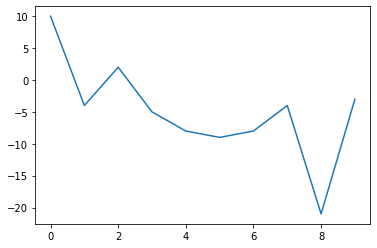

In [14]:
plt.plot(cum_Rew_win)

In [15]:
f = Forest(size,indiviual_reward_importance,social_reward_importance, p_change_wind, type_plane, P_burn, P_set_fire, P_fire_depend_on_wind)
print(f.grid_env)
print(f.grid_type)
agents_2 = Agent(f,g.make_arch([2, 2, 2]), 1,True)
r_2 = agents_2.live_one_episode()
print(f.grid_env)
print(f.grid_type)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[ 1.  2.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1. -1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 2.  1.  1.  1.  0.  0.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  0.  0.  0.  0.  0.  1.]
 [ 2.  1.  1.  1.  1.  1.  1.  1.  1.  1.]]


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:792: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, order=order, subok=subok, copy=True)


video saved
[[2. 0. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 0. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 0. 0. 2. 2. 2. 2.]
 [2. 2. 2. 2. 0. 0. 0. 0. 0. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]]
[[ 1.  2.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1. -1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 2.  1.  1.  1.  0.  0.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  0.  0.  0.  0.  0.  1.]
 [ 2.  1.  1.  1.  1.  1.  1.  1.  1.  1.]]


In [ ]:
g = Genetic(f,0)
print(g.train())

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:792: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, order=order, subok=subok, copy=True)


|||||||___________________________________________ 13.3% GA is running...6 gen from 45

KeyboardInterrupt: ignored

In [ ]:
f = Forest(size,indiviual_reward_importance,social_reward_importance, p_change_wind, type_plane, P_burn, P_set_fire, P_fire_depend_on_wind)
agents_2 = Agent(f,g.make_arch([2, 2, 2]), 1,True)
r_2 = agents_2.live_one_episode()
#print("reward of "+str(i)+"th iteration is:" + str(r))
f.reset()

returdant
recived reward :  [[ 0. ]
 [ 0. ]
 [ 0. ]
 [ 0. ]
 [ 0. ]
 [-3.5]]
1111
recived reward :  [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [-4.]]
1111
returdant
recived reward :  [[ 0. ]
 [ 0. ]
 [ 0. ]
 [ 0. ]
 [ 0. ]
 [-3.5]]
1111
recived reward :  [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [-2.]]
1111
recived reward :  [[ 0. ]
 [ 0. ]
 [ 0. ]
 [ 0. ]
 [ 0. ]
 [-4.5]]
1111
returdant
returdant
recived reward :  [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [-6.]]
1111
returdant
recived reward :  [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [-6.]]
1111
returdant
returdant
recived reward :  [[ 0. ]
 [ 0. ]
 [ 0. ]
 [ 0. ]
 [ 0. ]
 [-4.5]]
1111
returdant
returdant
returdant
recived reward :  [[ 0. ]
 [ 0. ]
 [ 0. ]
 [ 0. ]
 [ 0. ]
 [-6.5]]


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:792: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, order=order, subok=subok, copy=True)


1111
returdant
returdant
recived reward :  [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [-7.]]
1111
returdant
recived reward :  [[ 0. ]
 [ 0. ]
 [ 0. ]
 [ 0. ]
 [ 0. ]
 [-5.5]]
1111
returdant
recived reward :  [[ 0. ]
 [ 0. ]
 [ 0. ]
 [ 0. ]
 [ 0. ]
 [-4.5]]
1111
returdant
returdant
recived reward :  [[ 0. ]
 [ 0. ]
 [ 0. ]
 [ 0. ]
 [ 0. ]
 [-6.5]]
1111
returdant
recived reward :  [[ 0. ]
 [ 0. ]
 [ 0. ]
 [ 0. ]
 [ 0. ]
 [-6.5]]
1111
returdant
returdant
recived reward :  [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [-3.]]
1111
returdant
recived reward :  [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [-2.]]
1111
returdant
recived reward :  [[ 0. ]
 [ 0. ]
 [ 0. ]
 [ 0. ]
 [ 0. ]
 [-1.5]]
1111
returdant
recived reward :  [[ 0. ]
 [ 0. ]
 [ 0. ]
 [ 0. ]
 [ 0. ]
 [-0.5]]
1111
video saved


In [ ]:
ep_sum = []
for i in r:
  sum = 0 
  for j in range(len(i)):
    sum = np.sum(i[j])
  ep_sum.append(sum)



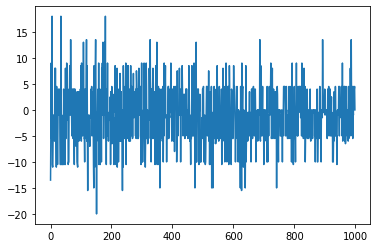

In [ ]:
import matplotlib.pyplot as plt
plt.plot(ep_sum)

In [ ]:
f = Forest(size,indiviual_reward_importance,social_reward_importance, p_change_wind, type_plane, P_burn, P_set_fire, P_fire_depend_on_wind)
g = Genetic(f)
r, agents = main_func(g.make_arch([2, 2, 2]),f)

episode Of :  0
-------------------------------------------------------
recived reward :  [[-11. ]
 [ -1.5]
 [ -6. ]
 [ -6. ]
 [-11. ]
 [ -6. ]]
recived reward :  [[ -6.5]
 [ -6.5]
 [ -7. ]
 [ -2. ]
 [-11.5]
 [ -6.5]]
recived reward :  [[ -2. ]
 [-11.5]
 [ -7. ]
 [-11.5]
 [ -7. ]
 [-11.5]]
recived reward :  [[-10.5]
 [ -6. ]
 [ -9. ]
 [-10.5]
 [ -6. ]
 [-10.5]]
recived reward :  [[-12. ]
 [-11.5]
 [-11.5]
 [-16.5]
 [-16.5]
 [-16.5]]


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:792: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, order=order, subok=subok, copy=True)


Streaming output truncated to the last 5000 lines.
episode Of :  375
-------------------------------------------------------
recived reward :  [[ 0.]
 [ 0.]
 [-5.]
 [ 0.]
 [-5.]
 [ 0.]]
episode Of :  376
-------------------------------------------------------
recived reward :  [[-0.5]
 [ 4.5]
 [ 0. ]
 [ 0. ]
 [-5. ]
 [ 0. ]]
episode Of :  377
-------------------------------------------------------
recived reward :  [[ 0. ]
 [-5. ]
 [ 0. ]
 [ 4.5]
 [ 4.5]
 [ 0. ]]
episode Of :  378
-------------------------------------------------------
recived reward :  [[ 0. ]
 [ 0. ]
 [ 4.5]
 [-0.5]
 [-0.5]
 [-5. ]]
episode Of :  379
-------------------------------------------------------
recived reward :  [[ 4.5]
 [ 0. ]
 [ 0. ]
 [ 0. ]
 [-5. ]
 [-0.5]]
episode Of :  380
-------------------------------------------------------
recived reward :  [[4.5]
 [0. ]
 [0. ]
 [0. ]
 [0. ]
 [0. ]]
episode Of :  381
-------------------------------------------------------
recived reward :  [[ 4. ]
 [-0.5]
 [ 0. ]

In [ ]:
for a in agents.all_agents:
  a.save_checkpoint()

In [ ]:
f = Forest(40,indiviual_reward_importance,social_reward_importance, p_change_wind, type_plane, P_burn, P_set_fire, P_fire_depend_on_wind)
g = Genetic(f,0)
r, agents = main_func(g.make_arch([2, 2, 2]),f,1)
for a in agents.all_agents:
  a.save_checkpoint()

episode Of :  0
-------------------------------------------------------
recived reward :  [[ 0.5]
 [-4. ]
 [-4. ]
 [ 0. ]
 [ 0.5]
 [-4. ]]
recived reward :  [[ -6.5]
 [-11.5]
 [ -2.5]
 [ -2.5]
 [ -2. ]
 [ -7. ]]


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:792: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, order=order, subok=subok, copy=True)


Streaming output truncated to the last 5000 lines.
episode Of :  375
-------------------------------------------------------
recived reward :  [[ 4. ]
 [-0.5]
 [ 4. ]
 [ 0. ]
 [ 0. ]
 [ 0. ]]
episode Of :  376
-------------------------------------------------------
recived reward :  [[ 0.]
 [ 0.]
 [ 0.]
 [-1.]
 [ 0.]
 [ 4.]]
episode Of :  377
-------------------------------------------------------
recived reward :  [[ 0. ]
 [ 0. ]
 [ 4. ]
 [-1. ]
 [-0.5]
 [-5. ]]
episode Of :  378
-------------------------------------------------------
recived reward :  [[ 4.5]
 [ 0. ]
 [-5. ]
 [ 4. ]
 [ 0. ]
 [ 4. ]]
episode Of :  379
-------------------------------------------------------
recived reward :  [[-5.]
 [ 0.]
 [ 0.]
 [-1.]
 [ 0.]
 [-5.]]
episode Of :  380
-------------------------------------------------------
recived reward :  [[-5. ]
 [ 0. ]
 [ 0. ]
 [ 0. ]
 [-5. ]
 [-0.5]]
episode Of :  381
-------------------------------------------------------
recived reward :  [[-0.5]
 [-5. ]
 [ 0. ]

In [ ]:
ep_avg = []
for i in r:
  ep_avg.append(np.mean(i))



In [ ]:
for x in r:
  print(np.mean(x))

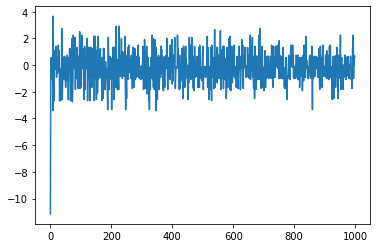

In [ ]:
plt.plot(ep_avg)

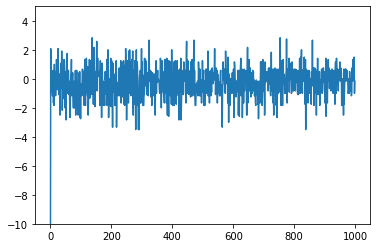

In [ ]:
plt.ylim([-10, 5])
plt.plot(ep_avg)

In [ ]:
cum_Rew = []
cum_Rew_win = []
k = 1
for i in r:
  sum = 0 
  for j in range(len(i)):
    sum = np.sum(i[j])
    sum = int(sum)
  cum_Rew.append(sum)
  if k > 100 :
    x = np.sum(cum_Rew[k-100:k])
    s = (sum + int(x) )/101
    cum_Rew_win.append(s)
  else:
    cum_Rew_win.append(sum)
  k += 1

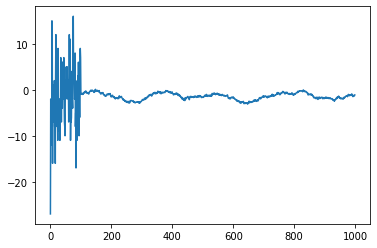

In [ ]:
plt.plot(cum_Rew_win)

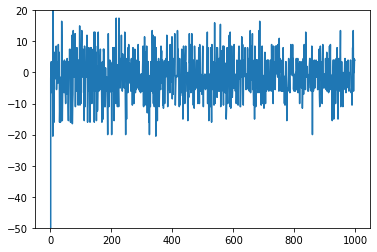

In [ ]:
import matplotlib.pyplot as plt
plt.ylim([-50, 20])
plt.plot(ep_sum)

In [ ]:
f = Forest(60,indiviual_reward_importance,social_reward_importance, p_change_wind, type_plane, P_burn, P_set_fire, P_fire_depend_on_wind)
g = Genetic(f,0)
r, agents = main_func(g.make_arch([2, 2, 2]),f,1)
for a in agents.all_agents:
  a.save_checkpoint()

episode Of :  0
-------------------------------------------------------
recived reward :  [[-4.5]
 [-0.5]
 [-4.5]
 [-5.5]
 [-0.5]
 [-4.5]]
recived reward :  [[-5.5]
 [-5.5]
 [-9.5]
 [-0.5]
 [-5.5]
 [ 0. ]]


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:792: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, order=order, subok=subok, copy=True)


Streaming output truncated to the last 5000 lines.
episode Of :  375
-------------------------------------------------------
recived reward :  [[ 4.]
 [ 0.]
 [ 4.]
 [ 0.]
 [-5.]
 [ 0.]]
episode Of :  376
-------------------------------------------------------
recived reward :  [[ 4. ]
 [-5. ]
 [ 4. ]
 [-5. ]
 [ 4. ]
 [ 4.5]]
episode Of :  377
-------------------------------------------------------
recived reward :  [[ 0.]
 [-1.]
 [-5.]
 [-1.]
 [ 0.]
 [ 0.]]
episode Of :  378
-------------------------------------------------------
recived reward :  [[ 4. ]
 [ 0. ]
 [ 0. ]
 [-1. ]
 [ 0. ]
 [-0.5]]
episode Of :  379
-------------------------------------------------------
recived reward :  [[-5.]
 [-1.]
 [-5.]
 [ 0.]
 [ 0.]
 [ 0.]]
episode Of :  380
-------------------------------------------------------
recived reward :  [[-5.]
 [-5.]
 [ 0.]
 [-5.]
 [ 0.]
 [ 0.]]
episode Of :  381
-------------------------------------------------------
recived reward :  [[4. ]
 [0. ]
 [4. ]
 [0. ]
 [0. ]


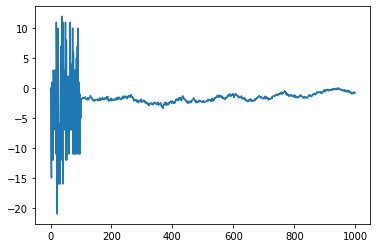

In [ ]:
cum_Rew = []
cum_Rew_win = []
k = 1
for i in r:
  sum = 0 
  for j in range(len(i)):
    sum = np.sum(i[j])
    sum = int(sum)
  cum_Rew.append(sum)
  if k > 100 :
    x = np.sum(cum_Rew[k-100:k])
    s = (sum + int(x) )/101
    cum_Rew_win.append(s)
  else:
    cum_Rew_win.append(sum)
  k += 1
plt.plot(cum_Rew_win) 

In [ ]:
f = Forest(100,indiviual_reward_importance,social_reward_importance, p_change_wind, type_plane, P_burn, P_set_fire, P_fire_depend_on_wind)
g = Genetic(f,0)
r, agents = main_func(g.make_arch([2, 2, 2]),f,1)
for a in agents.all_agents:
  a.save_checkpoint()

episode Of :  0
-------------------------------------------------------
recived reward :  [[-4. ]
 [-4. ]
 [-5. ]
 [-4.5]
 [-5. ]
 [ 0. ]]


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:792: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, order=order, subok=subok, copy=True)


recived reward :  [[ -7.]
 [-11.]
 [ -6.]
 [ -6.]
 [ -7.]
 [ -6.]]
recived reward :  [[ -8.5]
 [-13.5]
 [ -8.5]
 [ -8.5]
 [-13.5]
 [ -8.5]]
recived reward :  [[ -6. ]
 [ -6. ]
 [-15. ]
 [-10.5]
 [-10. ]
 [ -6. ]]
recived reward :  [[-15.5]
 [-15.5]
 [-15.5]
 [-10.5]
 [-10.5]
 [-10.5]]
recived reward :  [[-11. ]
 [-10. ]
 [-10. ]
 [ -5.5]
 [-11. ]
 [-11. ]]
recived reward :  [[ -9.5]
 [ -4.5]
 [-13.5]
 [ -4. ]
 [ -8.5]
 [ -9.5]]
recived reward :  [[-9.5]
 [-9.5]
 [-8.5]
 [-8.5]
 [-9.5]
 [-8.5]]
recived reward :  [[-14.5]
 [ -9.5]
 [ -5.5]
 [ -9.5]
 [-14.5]
 [ -5.5]]
recived reward :  [[-14.5]
 [ -9.5]
 [ -5.5]
 [-14.5]
 [ -9.5]
 [-14.5]]
recived reward :  [[-14. ]
 [-14. ]
 [-14. ]
 [-14.5]
 [-14. ]
 [-15. ]]
recived reward :  [[ -8.]
 [-17.]
 [-12.]
 [-12.]
 [-12.]
 [-13.]]
recived reward :  [[ -5. ]
 [ -9. ]
 [-14. ]
 [ -4.5]
 [ -5. ]
 [ -5. ]]
recived reward :  [[-13.5]
 [-13.5]
 [-18.5]
 [ -9. ]
 [-13.5]
 [-18.5]]
recived reward :  [[ -9.]
 [ -9.]
 [-13.]
 [-18.]
 [-13.]
 [-13.]]
re

In [ ]:
print(f.grid_env)

In [ ]:
f.P_transition()

In [ ]:
print(f.grid_env)

[[0. 0. 0. 0. 0. 0. 1. 2. 1. 0.]
 [0. 0. 0. 0. 0. 1. 1. 2. 2. 0.]
 [0. 0. 0. 0. 0. 1. 0. 2. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 1. 2. 1. 0. 0.]
 [0. 0. 0. 0. 1. 2. 2. 2. 1. 0.]
 [0. 0. 0. 0. 1. 1. 2. 1. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 2. 1. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [ ]:
print(f.grid_env)

[[0. 0. 0. 0. 0. 0. 1. 2. 1. 0.]
 [0. 0. 0. 0. 0. 1. 1. 2. 2. 0.]
 [0. 0. 0. 0. 0. 1. 0. 2. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 1. 2. 1. 0. 0.]
 [0. 0. 0. 0. 1. 2. 2. 2. 1. 0.]
 [0. 0. 0. 0. 1. 1. 2. 1. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 2. 1. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [ ]:
f.terminated()

False

In [ ]:
f.reset()

In [ ]:
f.terminated()

True

In [ ]:
f.grid_env[5][5] = 0
f.terminated()

False

In [ ]:
for i in range(10):
    f.init_grid(type_plane)
    f.render([[0,0],[4,4]])
f.save_episode()

In [ ]:
A = np.ones((5,5))
B = np.pad(A, ((2,3),(4,1)))

In [ ]:
B

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])